#Preprocesamiento de datos

In [ ]:
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
sns.set_style(style='white')

In [ ]:
!gdown --id 1Mpk-C-msTdfZJK88IiaEHrV4Jez4l0PV #https://drive.google.com/file/d/1Mpk-C-msTdfZJK88IiaEHrV4Jez4l0PV/view?usp=sharing
!unzip ObesityDataSet_raw_and_data_sinthetic.zip

Downloading...
From: https://drive.google.com/uc?id=1Mpk-C-msTdfZJK88IiaEHrV4Jez4l0PV
To: /content/ObesityDataSet_raw_and_data_sinthetic.zip
100% 119k/119k [00:00<00:00, 38.7MB/s]
Archive:  ObesityDataSet_raw_and_data_sinthetic.zip
replace ObesityDataSet_raw_and_data_sinthetic.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ObesityDataSet_raw_and_data_sinthetic.arff  
  inflating: ObesityDataSet_raw_and_data_sinthetic.csv  


In [ ]:
data=pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [ ]:
numeric=["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"]
ordinal=["CAEC","CALC"]
flags=["family_history_with_overweight","FAVC","SMOKE","SCC"]
categorical=["MTRANS","Gender"]

In [ ]:
data.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [ ]:
data["CAEC"]=data["CAEC"].map({"no":0,"Sometimes":1,"Frequently":2,"Always":3})

In [ ]:
data["CALC"]=data["CALC"].map({"no":0,"Sometimes":1,"Frequently":2,"Always":3})

In [ ]:
#Se usa la función get_dummies para codificar en one hot encoding los datos categóricos ("MTRANS" y "Gender") y el drop_first para no tener columnas altamente correlacionadas
data = pd.get_dummies(data, columns=categorical, drop_first=True)
data.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Gender_Male
0,21.0,1.62,64.0,yes,no,2.0,3.0,1,no,2.0,no,0.0,1.0,0,Normal_Weight,0,0,1,0,0
1,21.0,1.52,56.0,yes,no,3.0,3.0,1,yes,3.0,yes,3.0,0.0,1,Normal_Weight,0,0,1,0,0
2,23.0,1.80,77.0,yes,no,2.0,3.0,1,no,2.0,no,2.0,1.0,2,Normal_Weight,0,0,1,0,1
3,27.0,1.80,87.0,no,no,3.0,3.0,1,no,2.0,no,2.0,0.0,2,Overweight_Level_I,0,0,0,1,1
4,22.0,1.78,89.8,no,no,2.0,1.0,1,no,2.0,no,0.0,0.0,1,Overweight_Level_II,0,0,1,0,1


In [ ]:
#Codificacion para las variables con datos binarios
for column in flags:
    data[column]=data[column].map({"yes":1,"no":0})

In [ ]:
data.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Gender_Male
0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,Normal_Weight,0,0,1,0,0
1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,Normal_Weight,0,0,1,0,0
2,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,Normal_Weight,0,0,1,0,1
3,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,Overweight_Level_I,0,0,0,1,1
4,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,Overweight_Level_II,0,0,1,0,1


In [ ]:
#Codificacion para la variable objetivo
data["NObeyesdad_num"]=data["NObeyesdad"].map({"Insufficient_Weight":0,"Normal_Weight":1,"Overweight_Level_I":2,
                                           "Overweight_Level_II":3,"Obesity_Type_I":4,"Obesity_Type_II":5,
                                           "Obesity_Type_III":6})

In [ ]:
#Creacion de la variable BMI (Indice de masa corporal)
data["BMI"]=data["Weight"]/(data["Height"]*data["Height"])

In [ ]:
continuous_features_train=data[['Age', 'Height', 'Weight','BMI', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'NObeyesdad_num',
       'MTRANS_Bike',	'MTRANS_Motorbike',	'MTRANS_Public_Transportation',	'MTRANS_Walking',	'Gender_Male']]

#Generar conjunto de datos de entrenamiento y pruebas

In [ ]:
#Separamos la data en variables independientes (x) y dependientes (y) para poder entrenarlas
#En el conjunto de datos x se replican todos las columnas después del procesamiento excluyendo al target ["NObeyesdad","NObeyesdad_num"]
#En el conjunto de datos y solo consideta la columna del target ["NObeyesdad_num"]
x = data.drop(["NObeyesdad","NObeyesdad_num"], axis=1)
y = data["NObeyesdad_num"]

In [ ]:
#Mediante la función "train_test_split" usaremos el 20% de la data para probar el modelo 
#El parámetro "random state" nos sirve para obtener la misma secuencia de "números aleatorios"
#El parámetro "stratify" nos brindará el mismo número de clases en ambos conjuntos de datos 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"x Train shape: {x_train.shape}")
print(f"x Test shape: {x_test.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"y Test shape: {y_test.shape}")

x Train shape: (1688, 20)
x Test shape: (423, 20)
y Train shape: (1688,)
y Test shape: (423,)


In [ ]:
#Se muestra la información del conjunto de datos x_train
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 442 to 1329
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1688 non-null   float64
 1   Height                          1688 non-null   float64
 2   Weight                          1688 non-null   float64
 3   family_history_with_overweight  1688 non-null   int64  
 4   FAVC                            1688 non-null   int64  
 5   FCVC                            1688 non-null   float64
 6   NCP                             1688 non-null   float64
 7   CAEC                            1688 non-null   int64  
 8   SMOKE                           1688 non-null   int64  
 9   CH2O                            1688 non-null   float64
 10  SCC                             1688 non-null   int64  
 11  FAF                             1688 non-null   float64
 12  TUE                             

#Configuraciones

In [ ]:
#Función donde se envía el modelo y genera la matriz de confusión basándose en los datos predichos
def plot_confusion_matrix(model):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix","\n")
    index = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"] 
    columns = index
    conf_matrix = pd.DataFrame(cm,columns,index)  
    plt.figure(figsize=(10,6))                     
    sns.heatmap(conf_matrix, annot = True)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
    print("\n")   

In [ ]:
#Función que construye un reporte mostrando las principales métricas de classificación como precision y recall
def get_test_report(model):
    test_pred = model.predict(x_test)
    return(classification_report(y_test, test_pred))

In [ ]:
#Función que muestra características que más aportan al modelo en orden de importancia
def get_features(model):
  importances = pd.DataFrame({"columns":x_train.columns, "importances":model.feature_importances_}).sort_values("importances", ascending=False)
  return(importances.style.bar())

#Construir los modelos

##Redes neuronales
Adaptado de https://keras.io/examples/structured_data/structured_data_classification_from_scratch/ 

In [ ]:
#Se genera la función "tf.data.Dataset" para convertir dataframe de panda a dataset de tensor flow
def dataframe_to_dataset(df_x, df_y):
    ds = tf.data.Dataset.from_tensor_slices((dict(df_x), df_y))
    ds = ds.shuffle(buffer_size=len(df_x))
    return ds
#Se generan los conjuntos de datos de entrenamiento y validación a formato de tensor flow
train_ds = dataframe_to_dataset(x_train, y_train)
val_ds = dataframe_to_dataset(x_test, y_test)

In [ ]:
#Se muestran el formato de los campos en el conjunto de datos
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Age': <tf.Tensor: shape=(), dtype=float64, numpy=26.0>, 'Height': <tf.Tensor: shape=(), dtype=float64, numpy=1.72>, 'Weight': <tf.Tensor: shape=(), dtype=float64, numpy=65.0>, 'family_history_with_overweight': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'FAVC': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'FCVC': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>, 'NCP': <tf.Tensor: shape=(), dtype=float64, numpy=3.0>, 'CAEC': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'SMOKE': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'CH2O': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>, 'SCC': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'FAF': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'TUE': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, 'CALC': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'MTRANS_Bike': <tf.Tensor: shape=(), dtype=uint8, numpy=0>, 'MTRANS_Motorbike': <tf.Tensor: shape=(), dtype=uint8, numpy=0>, 'MTRANS_Public_Transportation': <tf.Tensor: shape=(), dtype=uint

In [ ]:
#Se configura el tamaño del lote (batch) para los conjuntos de datos
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

print(train_ds, val_ds)

<BatchDataset shapes: ({Age: (None,), Height: (None,), Weight: (None,), family_history_with_overweight: (None,), FAVC: (None,), FCVC: (None,), NCP: (None,), CAEC: (None,), SMOKE: (None,), CH2O: (None,), SCC: (None,), FAF: (None,), TUE: (None,), CALC: (None,), MTRANS_Bike: (None,), MTRANS_Motorbike: (None,), MTRANS_Public_Transportation: (None,), MTRANS_Walking: (None,), Gender_Male: (None,), BMI: (None,)}, (None,)), types: ({Age: tf.float64, Height: tf.float64, Weight: tf.float64, family_history_with_overweight: tf.int64, FAVC: tf.int64, FCVC: tf.float64, NCP: tf.float64, CAEC: tf.int64, SMOKE: tf.int64, CH2O: tf.float64, SCC: tf.int64, FAF: tf.float64, TUE: tf.float64, CALC: tf.int64, MTRANS_Bike: tf.uint8, MTRANS_Motorbike: tf.uint8, MTRANS_Public_Transportation: tf.uint8, MTRANS_Walking: tf.uint8, Gender_Male: tf.uint8, BMI: tf.float64}, tf.int64)> <BatchDataset shapes: ({Age: (None,), Height: (None,), Weight: (None,), family_history_with_overweight: (None,), FAVC: (None,), FCVC: (N

In [ ]:
#Se definen las funciones para codificar los valores de tipo numérico (Normalizar) y las del tipo categórico
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_numerical_feature(feature, name, dataset):
    # Crear la capa de Normalization para las características
    normalizer = Normalization()

    # Preparar el conjunto de datos con solo nuestros datos de interés
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprender las estadísticas de los datos 
    normalizer.adapt(feature_ds)

    # Normalizalizar la función de entrada
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Crear una capa de búsqueda que convierta caracteres en enteros
    lookup = lookup_class(output_mode="binary")

    # Preparar el conjunto de datos con solo nuestros datos de interés
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprender los posibles valores de los caracteres y asignarles valores enteros fijos
    lookup.adapt(feature_ds)

    # Cambiar los caracteres de entrada a indices enteros 
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:
# Creación del modelo

# Definir las entradas del modelo
# Características categóricas como enteros
family_history_with_overweight = keras.Input(shape=(1,), name="family_history_with_overweight", dtype="int64")
FAVC = keras.Input(shape=(1,), name="FAVC", dtype="int64")
CAEC = keras.Input(shape=(1,), name="CAEC", dtype="int64")
SMOKE = keras.Input(shape=(1,), name="SMOKE", dtype="int64")
SCC = keras.Input(shape=(1,), name="SCC", dtype="int64")
CALC = keras.Input(shape=(1,), name="CALC", dtype="int64")
MTRANS_Bike = keras.Input(shape=(1,), name="MTRANS_Bike", dtype="int64")  
MTRANS_Motorbike = keras.Input(shape=(1,), name="MTRANS_Motorbike", dtype="int64") 
MTRANS_Public_Transportation = keras.Input(shape=(1,), name="MTRANS_Public_Transportation", dtype="int64")
MTRANS_Walking = keras.Input(shape=(1,), name="MTRANS_Walking", dtype="int64")
Gender_Male = keras.Input(shape=(1,), name="Gender_Male", dtype="int64")

# Características numéricas
Age = keras.Input(shape=(1,), name="Age")
Height = keras.Input(shape=(1,), name="Height")
Weight = keras.Input(shape=(1,), name="Weight")
FCVC = keras.Input(shape=(1,), name="FCVC")
NCP = keras.Input(shape=(1,), name="NCP")
CH2O = keras.Input(shape=(1,), name="CH2O")
FAF = keras.Input(shape=(1,), name="FAF")
TUE = keras.Input(shape=(1,), name="TUE")
BMI = keras.Input(shape=(1,), name="BMI")

all_inputs = [
    family_history_with_overweight, 
      FAVC, 
      CAEC, 
      SMOKE, 
      SCC,
      CALC, 
      MTRANS_Bike, 
      MTRANS_Motorbike,
      MTRANS_Public_Transportation, 
      MTRANS_Walking, 
      Gender_Male, 
      BMI,
      Age, 
      Height, 
      Weight, 
      FCVC, 
      NCP, 
      CH2O, 
      FAF, 
      TUE,
]

# Normalización de las variables
# Características categóricas enteras
family_history_with_overweight_encoded = encode_categorical_feature(family_history_with_overweight, "family_history_with_overweight", train_ds, False)
FAVC_encoded = encode_categorical_feature(FAVC, "FAVC", train_ds, False)
CAEC_encoded = encode_categorical_feature(CAEC, "CAEC", train_ds, False)
SMOKE_encoded = encode_categorical_feature(SMOKE, "SMOKE", train_ds, False)
SCC_encoded = encode_categorical_feature(SCC, "SCC", train_ds, False)
CALC_encoded = encode_categorical_feature(CALC, "CALC", train_ds, False)
MTRANS_Bike_encoded = encode_categorical_feature(MTRANS_Bike, "MTRANS_Bike", train_ds, False)
MTRANS_Motorbike_encoded = encode_categorical_feature(MTRANS_Motorbike, "MTRANS_Motorbike", train_ds, False) 
MTRANS_Public_Transportation_encoded = encode_categorical_feature(MTRANS_Public_Transportation, "MTRANS_Public_Transportation", train_ds, False)
MTRANS_Walking_encoded = encode_categorical_feature(MTRANS_Walking, "MTRANS_Walking", train_ds, False)
Gender_Male_encoded = encode_categorical_feature(Gender_Male, "Gender_Male", train_ds, False)

# Características numéricas
Age_encoded = encode_numerical_feature(Age, "Age", train_ds)
Height_encoded = encode_numerical_feature(Height, "Height", train_ds)
Weight_encoded = encode_numerical_feature(Weight, "Weight", train_ds)
FCVC_encoded = encode_numerical_feature(FCVC, "FCVC", train_ds)
NCP_encoded = encode_numerical_feature(NCP, "NCP", train_ds)
CH2O_encoded = encode_numerical_feature(CH2O, "CH2O", train_ds)
FAF_encoded = encode_numerical_feature(FAF, "FAF", train_ds)
TUE_encoded = encode_numerical_feature(TUE, "TUE", train_ds)
BMI_encoded = encode_numerical_feature(BMI, "BMI", train_ds)

all_features = layers.concatenate(
    [
      family_history_with_overweight_encoded, 
      FAVC_encoded, 
      CAEC_encoded, 
      SMOKE_encoded, 
      SCC_encoded,
      CALC_encoded, 
      MTRANS_Bike_encoded, 
      MTRANS_Motorbike_encoded,
      MTRANS_Public_Transportation_encoded, 
      MTRANS_Walking_encoded, 
      Gender_Male_encoded, 
      BMI_encoded,
      Age_encoded, 
      Height_encoded, 
      Weight_encoded, 
      FCVC_encoded, 
      NCP_encoded, 
      CH2O_encoded, 
      FAF_encoded, 
      TUE_encoded
  ]
)

# Configuración del modelo de red neuronal con una salida con 7 neuronas con activación "softmax"
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(7, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

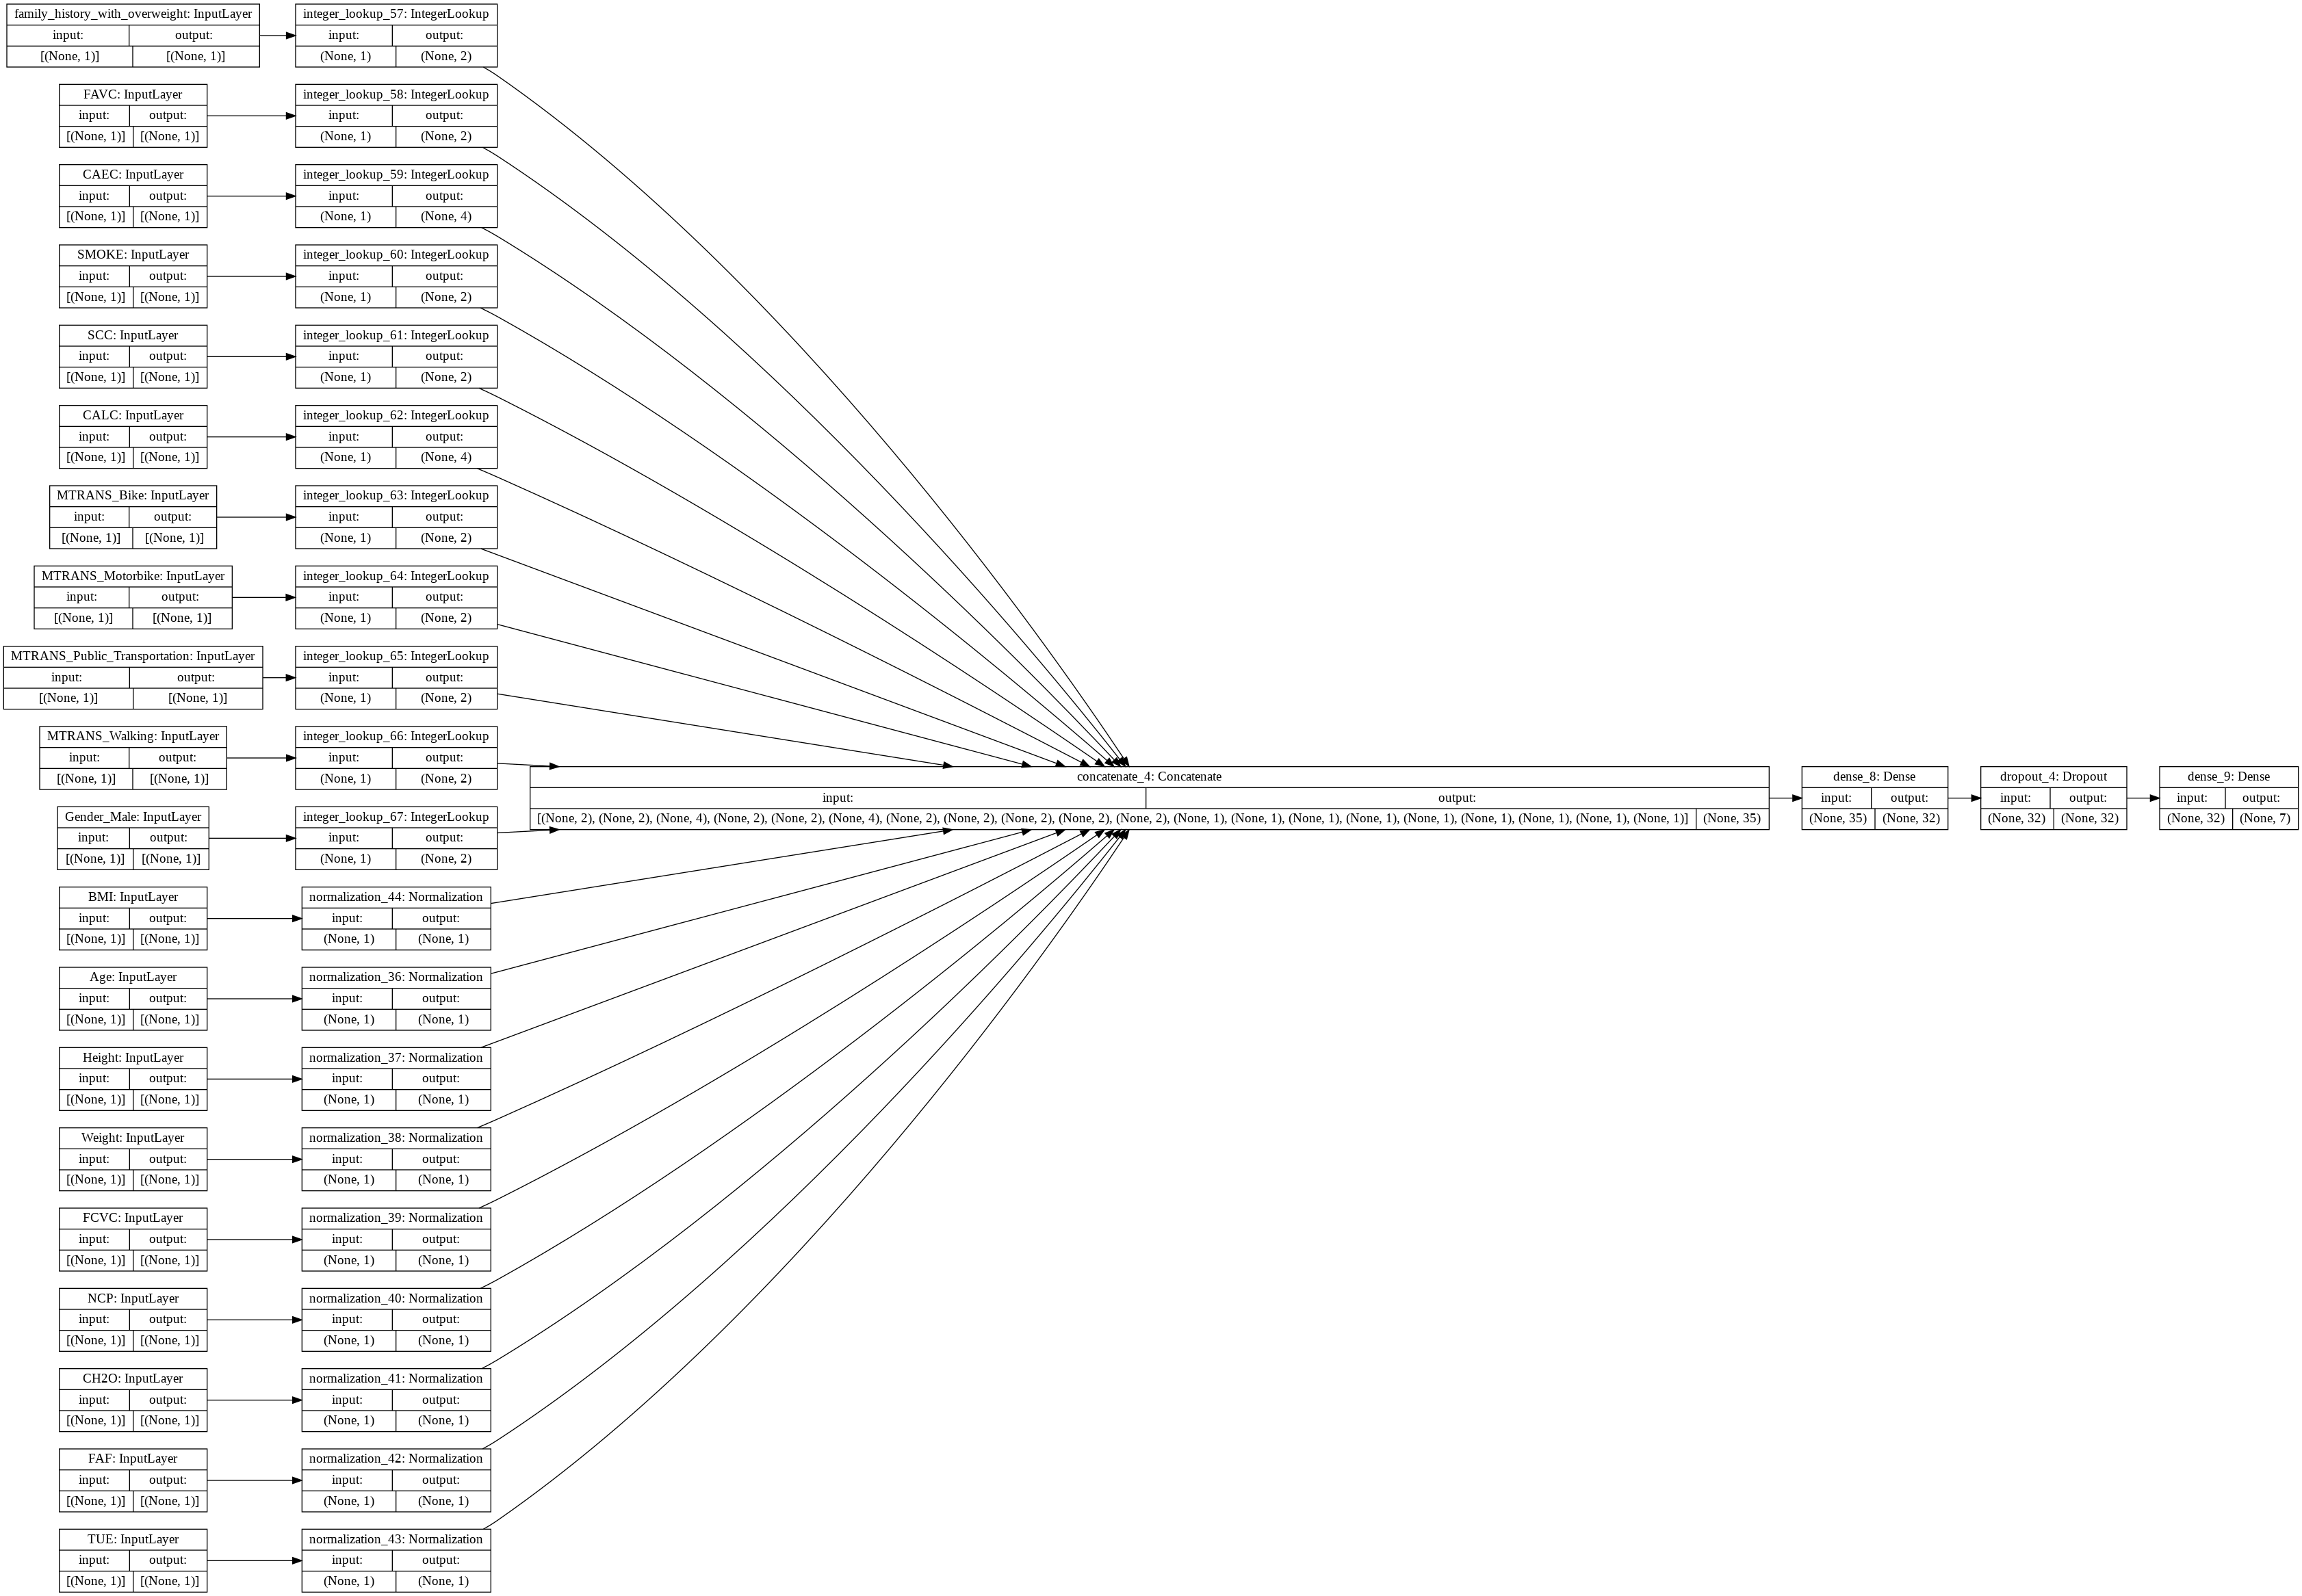

In [ ]:
# Arquitectura del modelo
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
# Entrenamiento del modelo en 300 épocas
history = model.fit(train_ds, epochs=300, validation_data=val_ds)

Epoch 1/300
53/53 [==============================] - 2s 19ms/step - loss: 2.0736 - accuracy: 0.1582 - val_loss: 1.8480 - val_accuracy: 0.2766
Epoch 2/300
53/53 [==============================] - 1s 10ms/step - loss: 1.7906 - accuracy: 0.3033 - val_loss: 1.6391 - val_accuracy: 0.3924
Epoch 3/300
53/53 [==============================] - 1s 10ms/step - loss: 1.6314 - accuracy: 0.3614 - val_loss: 1.4708 - val_accuracy: 0.4823
Epoch 4/300
53/53 [==============================] - 1s 10ms/step - loss: 1.4801 - accuracy: 0.4212 - val_loss: 1.3277 - val_accuracy: 0.5366
Epoch 5/300
53/53 [==============================] - 1s 10ms/step - loss: 1.3951 - accuracy: 0.4502 - val_loss: 1.2157 - val_accuracy: 0.6052
Epoch 6/300
53/53 [==============================] - 1s 10ms/step - loss: 1.2730 - accuracy: 0.4953 - val_loss: 1.1130 - val_accuracy: 0.6454
Epoch 7/300
53/53 [==============================] - 1s 10ms/step - loss: 1.1958 - accuracy: 0.5397 - val_loss: 1.0321 - val_accuracy: 0.6738
Epoch 

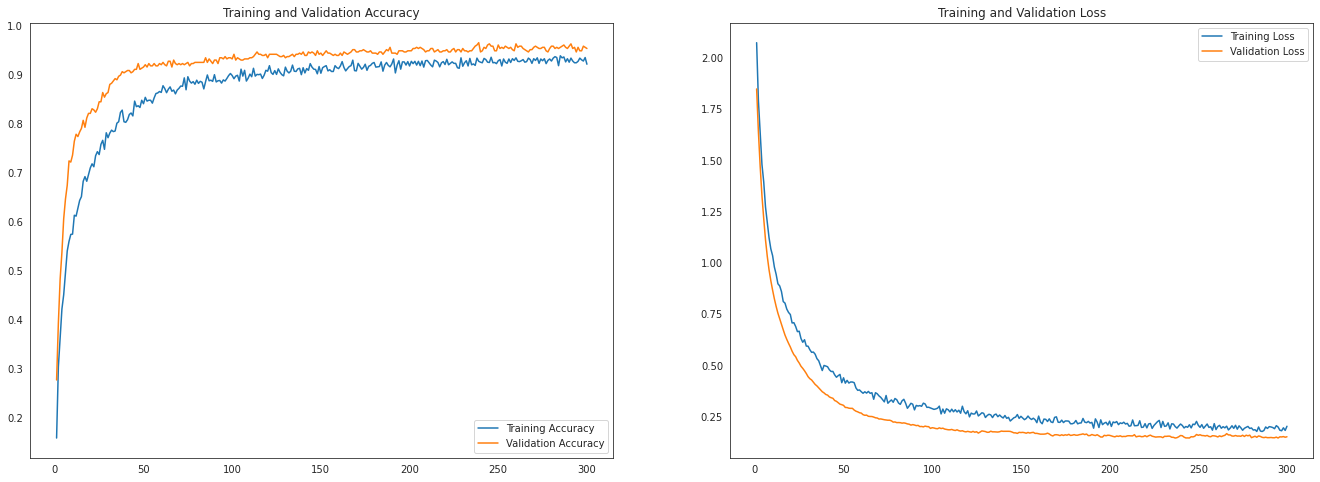

In [ ]:
# Reporte de las métricas de entrenamiento de ambos conjuntos de datos para el modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Prueba de predicción de un registro en el conjunto de datos de validación
sample = {
      "family_history_with_overweight": 0, 
      "FAVC": 0, 
      "CAEC": 1, 
      "SMOKE": 0, 
      "SCC": 0,
      "CALC": 0, 
      "MTRANS_Bike": 0, 
      "MTRANS_Motorbike": 0,
      "MTRANS_Public_Transportation": 1, 
      "MTRANS_Walking": 0, 
      "Gender_Male": 1, 
      "BMI": 28.342381,
      "Age": 22, 
      "Height": 1.78, 
      "Weight": 89.8, 
      "FCVC": 2.0, 
      "NCP": 1.0, 
      "CH2O": 2.0, 
      "FAF": 0.0, 
      "TUE": 0.0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
   predictions.round(2) 
)

[[0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
# Se realiza la predicción del conjunto de validación para mostras las estadísticas de los datos
y_pred = model.predict(val_ds) 

In [ ]:
# Se muestran las clases predichas de los datos de validación 
predicted_classes = np.argmax(y_pred, axis=1)
predicted_classes

array([0, 1, 6, 4, 3, 2, 3, 1, 3, 5, 0, 0, 4, 5, 0, 5, 1, 2, 6, 1, 1, 3,
       3, 5, 6, 5, 2, 4, 6, 1, 3, 2, 5, 5, 4, 1, 4, 0, 5, 0, 6, 0, 4, 4,
       6, 4, 0, 6, 3, 2, 4, 0, 5, 2, 6, 1, 4, 4, 4, 3, 6, 6, 0, 6, 5, 2,
       3, 0, 3, 3, 4, 5, 0, 0, 2, 0, 0, 0, 2, 2, 1, 6, 4, 2, 1, 5, 4, 5,
       6, 6, 2, 6, 2, 3, 5, 6, 0, 1, 4, 3, 3, 3, 3, 5, 6, 4, 2, 2, 6, 3,
       6, 1, 5, 4, 5, 4, 0, 4, 1, 1, 4, 6, 4, 0, 2, 3, 6, 6, 5, 3, 4, 6,
       0, 0, 0, 5, 2, 2, 4, 0, 5, 2, 4, 2, 2, 3, 6, 1, 0, 5, 5, 5, 4, 0,
       4, 3, 4, 2, 5, 6, 1, 3, 2, 3, 4, 6, 5, 6, 6, 4, 5, 1, 1, 3, 3, 5,
       3, 5, 1, 6, 3, 3, 2, 3, 0, 0, 1, 4, 2, 6, 5, 6, 4, 5, 1, 3, 6, 1,
       4, 2, 3, 4, 6, 6, 1, 0, 2, 5, 5, 4, 0, 4, 2, 6, 6, 6, 5, 2, 1, 6,
       1, 4, 2, 3, 1, 5, 3, 4, 3, 5, 6, 0, 2, 4, 6, 6, 1, 0, 3, 5, 4, 1,
       4, 2, 1, 5, 1, 0, 3, 3, 6, 1, 4, 6, 3, 4, 2, 4, 6, 3, 4, 2, 2, 2,
       5, 2, 6, 4, 5, 2, 2, 0, 4, 5, 6, 4, 3, 0, 3, 5, 2, 4, 6, 1, 1, 5,
       2, 6, 2, 4, 5, 1, 0, 1, 2, 0, 5, 5, 6, 1, 6,

In [ ]:
# Reporte de la matriz de confusión de los datos predichos generados por el modelo
confusion = confusion_matrix(y_test, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[53  1  0  0  0  0  0]
 [ 2 52  4  0  0  0  0]
 [ 0  5 50  3  0  0  0]
 [ 0  0  3 55  0  0  0]
 [ 0  0  0  0 70  0  0]
 [ 0  0  0  0  0 59  1]
 [ 0  0  0  0  0  1 64]]


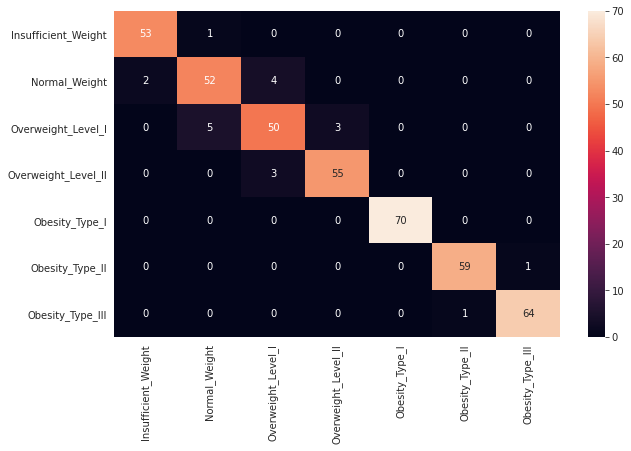

In [ ]:
# Reporte de la matriz de confusión de los datos predichos generados por el modelo usando matplotlib
cm =confusion_matrix(y_test, predicted_classes)  
index = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"]  
columns = index 
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)